In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS

# Data

In [12]:
raw = pd.read_excel("../data/raw.xlsx")
raw.head()

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Fiscal Year-end Month,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,...,Calendar Data Year and Quarter,Fiscal Data Year and Quarter,Assets - Total,Invested Capital - Total - Quarterly,Net Income (Loss),Stockholders Equity - Total,Capital Expenditures,Operating Activities - Net Cash Flow,Active/Inactive Status Marker,Standard Industry Classification Code
0,1045,1963-03-31,1963,1.0,12,INDL,C,D,STD,AAL,...,1963Q1,1963Q1,NaN,NaN,NaN,NaN,NaN,NaN,A,4512
1,1045,1963-06-30,1963,2.0,12,INDL,C,D,STD,AAL,...,1963Q2,1963Q2,NaN,NaN,NaN,NaN,NaN,NaN,A,4512
2,1045,1963-09-30,1963,3.0,12,INDL,C,D,STD,AAL,...,1963Q3,1963Q3,NaN,NaN,NaN,NaN,NaN,NaN,A,4512
3,1045,1963-12-31,1963,4.0,12,INDL,C,D,STD,AAL,...,1963Q4,1963Q4,NaN,NaN,NaN,NaN,NaN,NaN,A,4512
4,1045,1964-03-31,1964,1.0,12,INDL,C,D,STD,AAL,...,1964Q1,1964Q1,NaN,NaN,NaN,NaN,NaN,NaN,A,4512


In [13]:
raw.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Fiscal Year-end Month', 'Industry Format',
       'Level of Consolidation - Company Interim Descriptor',
       'Population Source', 'Data Format', 'Ticker Symbol', 'Company Name',
       'ISO Currency Code', 'Calendar Data Year and Quarter',
       'Fiscal Data Year and Quarter', 'Assets - Total',
       'Invested Capital - Total - Quarterly', 'Net Income (Loss)',
       'Stockholders Equity - Total', 'Capital Expenditures',
       'Operating Activities - Net Cash Flow', 'Active/Inactive Status Marker',
       'Standard Industry Classification Code'],
      dtype='object')

# functions

In [14]:
def rmv_outliner(data, method="3sigma", lo_q=0.01, hi_q=0.99, fill="delete"):
    '''
    remove outliner
    '''
    if method == "3sigma":
        _h = data.mean() + 3*data.std()
        _l = data.mean() - 3*data.std()
    elif method == "quantile":
        q = data.quantile([lo_q, hi_q])
        _l = q.iloc[0]
        _h = q.iloc[1]

    if fill == "delete":
        for colname in data.columns:
            data = data.copy()
            data = data[(data[colname] < _h[colname]) &
                        (data[colname] > _l[colname])]

    return data

In [15]:
# average invested capital
raw["pre_IC"] = raw["Invested Capital - Total - Quarterly"].shift()
raw["ave_IC"] = (
    raw["Invested Capital - Total - Quarterly"] + raw["pre_IC"]) * 1/2

# for companies which do not have Capital Expenditures: nan --> 0
raw[raw['Capital Expenditures'] == np.nan] = 0
raw["FCF"] = raw['Operating Activities - Net Cash Flow'] - \
    raw['Capital Expenditures']

raw["FCFROIC"] = raw["FCF"]/raw["ave_IC"]

# for those finance service companies
raw["ave_equity"] = (raw["Stockholders Equity - Total"] +
                     raw["Stockholders Equity - Total"].shift()) * 1/2
raw["ave_asset"] = (raw['Assets - Total'] +
                    raw['Assets - Total'].shift()) * 1/2

raw["NI_chg"] = raw["Net Income (Loss)"].diff().copy()
raw[raw["Fiscal Quarter"] == 1]["NI_chg"] = raw[raw["Fiscal Quarter"]
                                                == 1]["Net Income (Loss)"]

#####################################
raw["NI_chg"] = raw["NI_chg"]*4
raw["ROA"] = raw["NI_chg"]/raw["ave_asset"]
raw["ROE"] = raw["NI_chg"]/raw["ave_equity"]

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [16]:
# finance industry: SIC code 6000-6411
raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
raw["FCFROIC_ADJ"] = raw["FCFROIC"]
raw[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)]["FCFROIC_ADJ"] = raw[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)]["ROE"]

In [27]:
raw.shape

(184259, 34)

In [26]:
clean = rmv_outliner(raw[["FCFROIC"]])
clean.columns = ["filtered"]
clean

,filtered
99,-0.069590
100,0.001069
101,0.053648
102,0.069135
103,0.068862
...,...
184254,0.004033
184255,0.006054
184256,0.030491
184257,-0.000528


In [32]:
raw.filtered.describe()

count    131639.000000
mean          0.031370
std           0.254861
min         -16.554348
25%          -0.011894
50%           0.027660
75%           0.077097
max          13.474239
Name: filtered, dtype: float64

In [49]:
grouped = raw.groupby('Global Company Key')
FCFROIC_ADJ = pd.DataFrame(columns=["Global Company Key", "Data Date",
                                    "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC",
                                    "ROA", "ROE", "FCFROIC_ADJ", "filtered", "avg_fcfroic"])
for group in grouped:
    group = group[1].iloc[1:][["Global Company Key", "Data Date",
                               "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC",
                               "ROA", "ROE", "FCFROIC_ADJ"]].copy()
    clean = rmv_outliner(group[["FCFROIC"]])
    # remove outliners
    clean.columns = ["filtered"]
    group = group.merge(clean, left_index=True, right_index=True, how="left")
    # 10y average                         
    group[["avg_fcfroic", "avg_fcfroic_ajd"]] = group[["FCFROIC_ADJ", "filtered"]].rolling(40).mean().fillna(method="ffill")
    FCFROIC_ADJ = FCFROIC_ADJ.append(group, ignore_index=True)

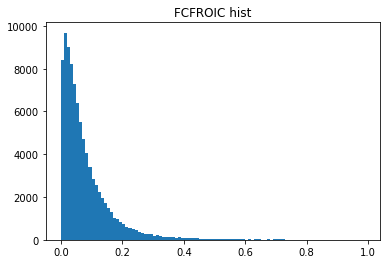

In [50]:
num = FCFROIC_ADJ["FCFROIC_ADJ"]
plt.hist(num, bins=np.arange(0, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist.png")
plt.show()

In [51]:
num.describe().to_frame("FCFROIC_ADJ")

,FCFROIC_ADJ
count,131628.000000
mean,0.043762
std,5.609486
min,-558.000000
25%,-0.011899
50%,0.027675
75%,0.077108
max,1943.333333


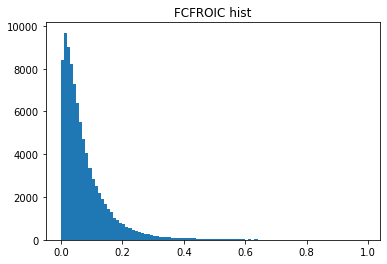

In [52]:
num = FCFROIC_ADJ["filtered"]
plt.hist(num, bins=np.arange(0, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist filtered.png")
plt.show()

In [53]:
num.describe().to_frame("filtered")

,filtered
count,130126.000000
mean,0.032316
std,0.269346
min,-21.500000
25%,-0.011351
50%,0.027612
75%,0.076154
max,50.715447


In [59]:
FCFROIC_ADJ[["filtered", "avg_fcfroic_ajd"]].describe()

,filtered,avg_fcfroic_ajd
count,130126.000000,63769.000000
mean,0.032316,0.038432
std,0.269346,0.091461
min,-21.500000,-0.460565
25%,-0.011351,0.005200
50%,0.027612,0.036391
75%,0.076154,0.065404
max,50.715447,2.674843


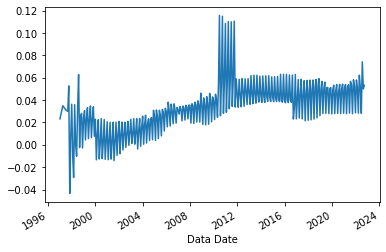

In [56]:
his_mean = FCFROIC_ADJ.groupby("Data Date").mean()
his_mean["avg_fcfroic"].dropna().plot()

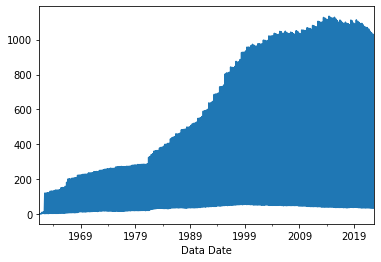

In [58]:
his_num = FCFROIC_ADJ.groupby("Data Date").count()
his_num["Global Company Key"].dropna().plot()

In [60]:
FCFROIC_ADJ.to_excel("../clean_data/FCFROIC_ADJ_1110.xlsx")